In [2]:
import nltk
import string
import re
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from lib_file import lib_path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import calendar
import pickle
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

C:\Users\user\anaconda3\envs\myproject\lib\site-packages\seaborn\utils.py:10: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy import stats


In [3]:
# Load dataset into a pandas dataframe
df = pd.read_csv('input/Webpages_Classification_test_data.csv').drop(['Unnamed: 0'], axis=1)
df.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://www.dutchthewiz.com/freeware/,36,175.67.214.68,China,com,complete,yes,38.5,0.0,"Decay suggest in 1315.. Current constitution, ...",good
1,http://www.collectiblejewels.com,32,188.120.171.121,Sweden,com,incomplete,yes,187.0,0.0,breast addict nudger whash ky darkie catholics...,good
2,http://www.deadlinedata.com,27,193.51.170.1,France,com,complete,yes,31.0,0.0,Nato's military stoic philosophy says to accep...,good
3,http://www.mil.fi/maavoimat/kalustoesittely/00...,56,13.237.35.44,Australia,fi,complete,yes,152.0,0.0,Night being newton. according to the formation...,good
4,http://www.avclub.com/content/node/24539,40,220.193.62.89,China,com,complete,yes,150.0,0.0,34 per two children. if we exercise simple pra...,good


In [4]:
df.shape

(361934, 11)

In [4]:
# Check for missing values
missing_values = df.isna().sum()
print("Missing Values in Dataset:")
print(missing_values)

Missing Values in Dataset:
url           0
url_len       0
ip_add        0
geo_loc       0
tld           0
who_is        0
https         0
js_len        0
js_obf_len    0
content       0
label         0
dtype: int64


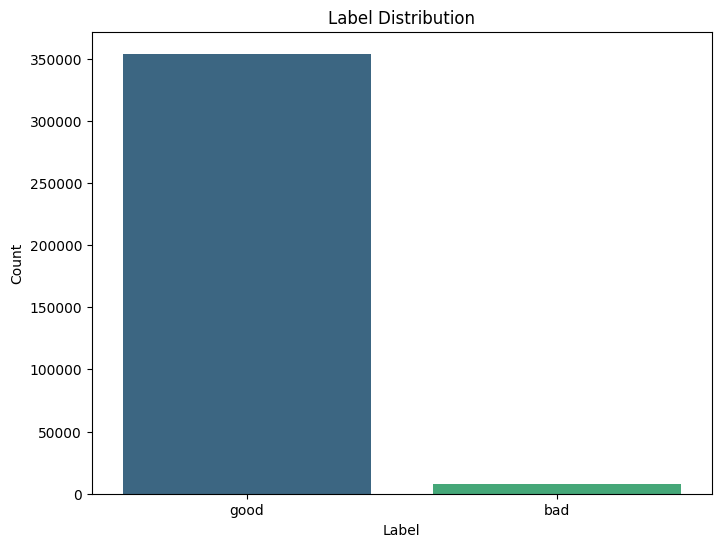

In [5]:
# Visualize the distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

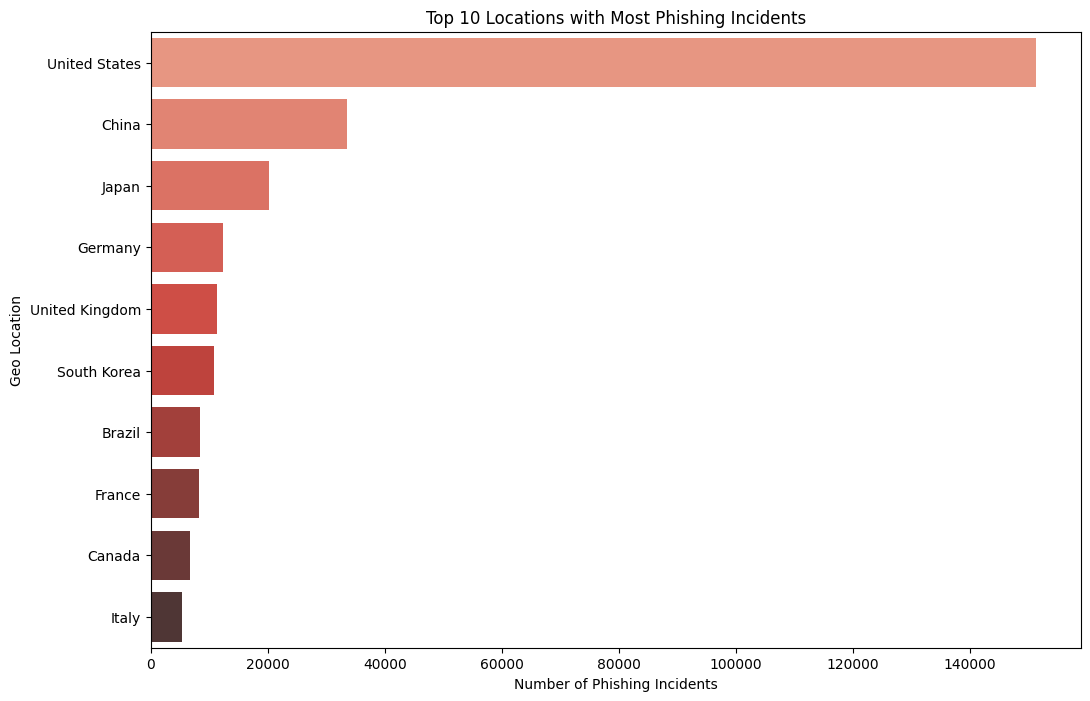

In [6]:
phishing_data = df[df['label'] == 'good']

# Count the occurrences of each location in phishing data
top_10_geo_loc = phishing_data['geo_loc'].value_counts().head(10)
# Plotting the top 10 geo locations for phishing
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_geo_loc.values, y=top_10_geo_loc.index, palette='Reds_d')
plt.title('Top 10 Locations with Most Phishing Incidents')
plt.xlabel('Number of Phishing Incidents')
plt.ylabel('Geo Location')
plt.show()


In [7]:
df1 = df.copy()

In [8]:
# Find the minimum size across all groups
min_group_size = df.groupby('label').size().min()
min_group_size

8062

In [9]:
# Sample from each group up to the minimum group size (if necessary)
df_reviews_untrimmed_sample = df.groupby('label').apply(
    lambda x: x.sample(min(min_group_size, 25000), random_state=42)
).reset_index(drop=True)

In [10]:
# Remove rows where content has less than 60 words
df_reviews_trimmed = df_reviews_untrimmed_sample[df_reviews_untrimmed_sample.content.str.split().str.len().ge(60)]

In [11]:
# Resample trimmed dataframe to make it uniformly distributed
df_reviews_sampled = df_reviews_trimmed.groupby('label').apply(
    lambda x: x.sample(4000, random_state=42)
).reset_index(drop=True)

# Randomly shuffle rows for aesthetics
df = df_reviews_sampled.sample(frac=1, random_state=42).reset_index(drop=True)
df.shape

(8000, 11)

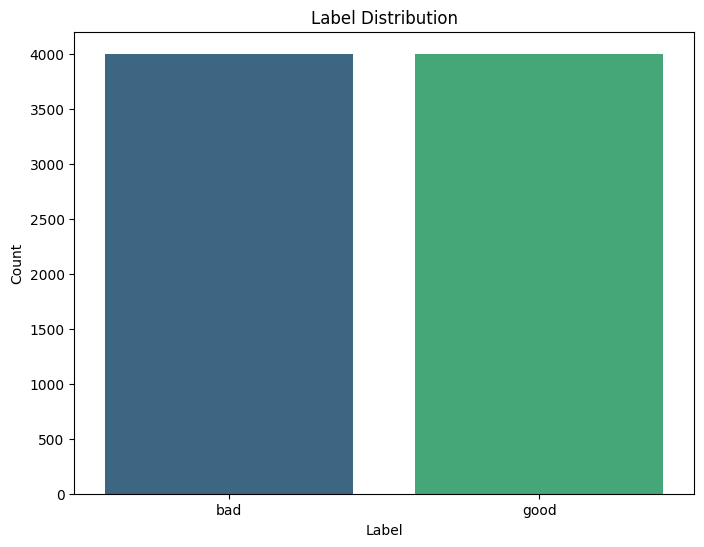

In [12]:
# Visualize the distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

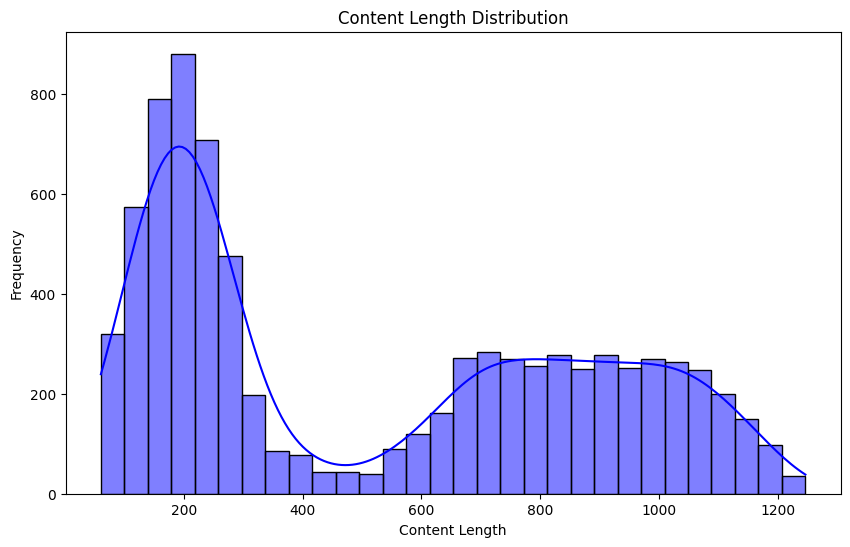

In [13]:
# Visualize the distribution of content lengths
df['content_length'] = df['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['content_length'], bins=30, kde=True, color='blue')
plt.title('Content Length Distribution')
plt.xlabel('Content Length')
plt.ylabel('Frequency')
plt.show()

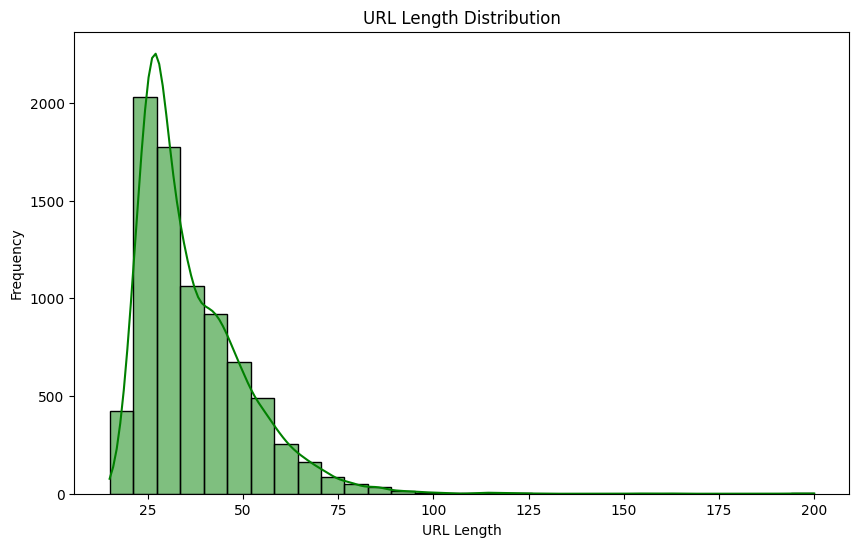

In [14]:
# Visualize the distribution of URL lengths
df['url_length'] = df['url'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
sns.histplot(df['url_length'], bins=30, kde=True, color='green')
plt.title('URL Length Distribution')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()



In [15]:
# Ordinal Encoding for categorical features
df['geo_loc'] = OrdinalEncoder().fit_transform(df.geo_loc.values.reshape(-1,1))
df['tld'] = OrdinalEncoder().fit_transform(df.tld.values.reshape(-1,1))
df['who_is'] = OrdinalEncoder().fit_transform(df.who_is.values.reshape(-1,1))
df['https'] = OrdinalEncoder().fit_transform(df.https.values.reshape(-1,1))
df['label'] = OrdinalEncoder().fit_transform(df.label.values.reshape(-1,1))
# Convert URL into a human-readable string that can be tokenized
df['url'] = df.url.apply(lambda x: ' '.join(x.split('://')[0].strip('www.').replace('.','/').split('/')))

In [16]:
# Text Preprocessing: Case folding, removing punctuation, and stopwords
tqdm.pandas()
stop = stopwords.words('english')

df.content = df.content.str.replace("[^\w\s]", "").str.lower()
df.content = df.content.progress_apply(
    lambda x: ' '.join([item for item in x.split() if item not in stop])
)
df.url = df.url.str.replace("[^\w\s]", "").str.lower()
df.url = df.url.progress_apply(
    lambda x: ' '.join([item for item in x.split() if item not in stop])
)


100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 144325.10it/s]


In [17]:
df['url'].value_counts()

url
http     7998
https       2
Name: count, dtype: int64

In [18]:
tfidf = TfidfVectorizer(
    min_df = 2,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)

tfidf.fit(df.url)
url_tfidf = tfidf.transform(df.url)

tfidf.fit(df.content)
content_tfidf = tfidf.transform(df.content)

In [19]:
df['url_cluster'] = MiniBatchKMeans(n_clusters=2, init_size=1024, batch_size=2048, random_state=20).fit_predict(url_tfidf)

df['content_cluster'] = MiniBatchKMeans(n_clusters=3, init_size=1024, batch_size=2048, random_state=20).fit_predict(content_tfidf)


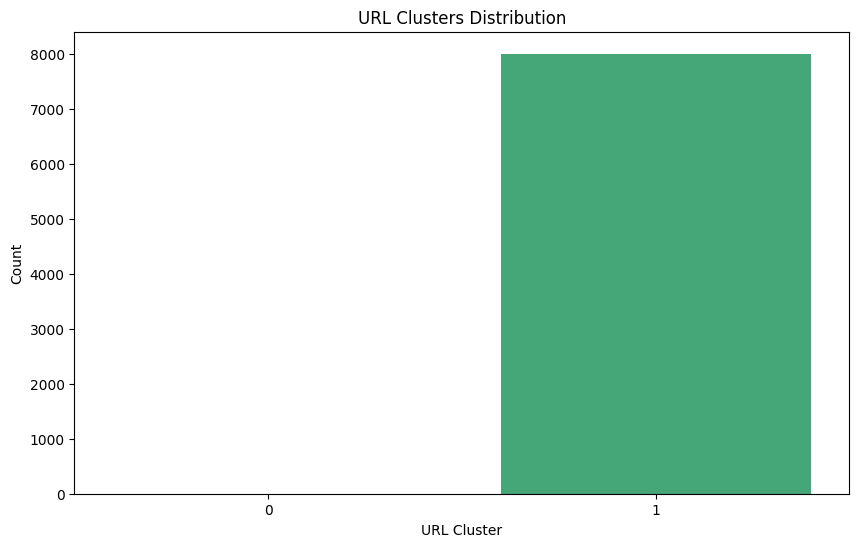

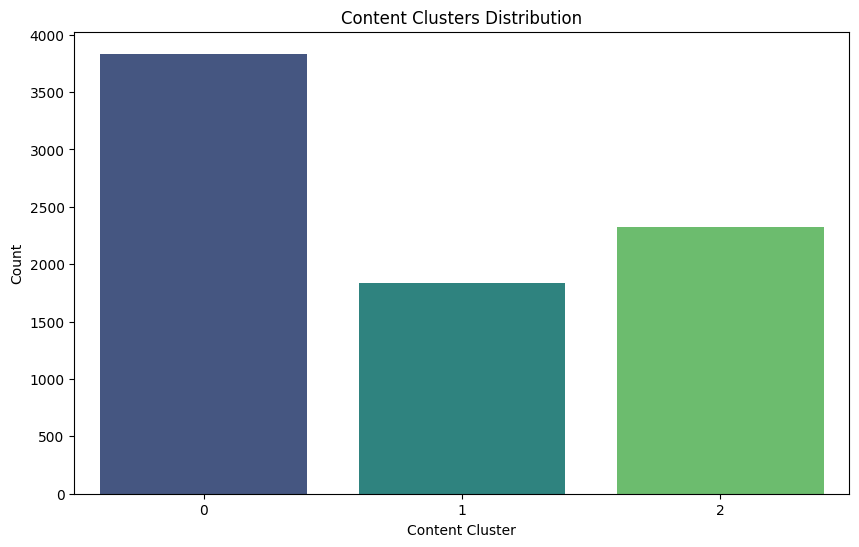

In [20]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='url_cluster', palette='viridis')
plt.title('URL Clusters Distribution')
plt.xlabel('URL Cluster')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='content_cluster', palette='viridis')
plt.title('Content Clusters Distribution')
plt.xlabel('Content Cluster')
plt.ylabel('Count')
plt.show()



In [21]:
df['content_cluster'].value_counts()

content_cluster
0    3834
2    2326
1    1840
Name: count, dtype: int64

## Dara Splitting

In [22]:
# Define features (X) and labels (y)
X = df[['url_cluster', 'url_length', 'geo_loc', 'tld', 'who_is', 'https', 'content_cluster']]
y = df.label

In [23]:
X.head()

,url_cluster,url_length,geo_loc,tld,who_is,https,content_cluster
0,1,49,135.0,30.0,0.0,0.0,0
1,1,30,135.0,30.0,1.0,0.0,0
2,1,18,24.0,107.0,1.0,0.0,0
3,1,26,28.0,16.0,1.0,1.0,0
4,1,27,29.0,30.0,0.0,1.0,2


In [24]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: label, dtype: float64

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6400, 7), (6400,), (1600, 7), (1600,))

## Model Implementation

## Support Vector Classifier

In [26]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', random_state=seed_value, C=1000)
svm_model = svm_model.fit(X_train.values, y_train.values.ravel())

In [27]:
svm_prediction = svm_model.predict(X_test.values)
print(svm_prediction.tolist())

[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0,

In [28]:
true_labels = y_test.values.ravel()
print(true_labels.tolist())

[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0,

**Result Analysis**

In [29]:
model_accuracy = accuracy_score(y_true=true_labels, y_pred=svm_prediction)
print(f"Validation accuracy of the SupportVectorClassifier model: {model_accuracy:.2f}%")

Validation accuracy of the SupportVectorClassifier model: 0.98%


In [30]:
print(classification_report(y_true=true_labels, y_pred=svm_prediction))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       800
         1.0       0.98      0.98      0.98       800

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



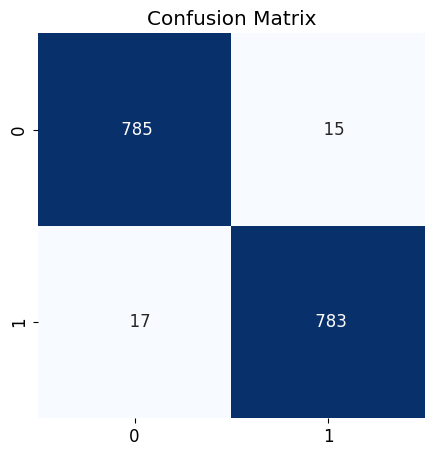

In [31]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size'] = 12
sns.heatmap(
    data=confusion_matrix(y_true=true_labels, y_pred=svm_prediction),
    fmt='4d',
    annot=True,
    cbar=False,
    cmap=plt.cm.Blues
)
plt.title(label='Confusion Matrix')
plt.show()

In [32]:
with open(file='Model/SupportVectorClassifier_model.pkl', mode='wb') as file:
    pickle.dump(obj=svm_model, file=file)

## AdaBoost Classifier

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)

# Train the model
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)

**Result Analysis**

In [34]:
model_accuracy = accuracy_score(y_true=true_labels, y_pred=y_pred)
print(f"Validation accuracy of the AdaBoostClassifier model: {model_accuracy:.2f}%")

Validation accuracy of the AdaBoostClassifier model: 0.98%


In [35]:
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       800
         1.0       0.98      0.98      0.98       800

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



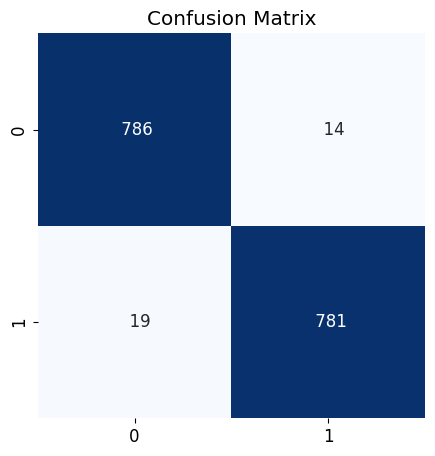

In [36]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size'] = 12
sns.heatmap(
    data=confusion_matrix(y_true=true_labels, y_pred=y_pred),
    fmt='4d',
    annot=True,
    cbar=False,
    cmap=plt.cm.Blues
)
plt.title(label='Confusion Matrix')
plt.show()

In [37]:
with open(file='Model/AdaBoostClassifier_model.pkl', mode='wb') as file:
    pickle.dump(obj=adaboost, file=file)

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [39]:
tok=Tokenizer()
tok.fit_on_texts(df["content"])
num_data=tok.texts_to_sequences(df["content"])
vocab_size=len(tok.word_index)+1
print("Unique Tokens size is {}".format(vocab_size))

Unique Tokens size is 15634


In [40]:
print(tok.word_index.items())

dict_items([("'97", 1), ('script', 2), ('x', 3), ('n', 4), ('code', 5), ('type', 6), ('var', 7), ('open', 8), ('javascript', 9), ('find', 10), ('window', 11), ('equal', 12), ('unescape', 13), ('myscript', 14), ('js', 15), ('src', 16), ('eval', 17), ('b', 18), ('y', 19), ('name', 20), ('numbers', 21), ('operators', 22), ('loop', 23), ('value', 24), ('line', 25), ('shift', 26), ('logical', 27), ('comments', 28), ('valueof', 29), ('function', 30), ('matching', 31), ('z', 32), ('perform', 33), ('john', 34), ('input', 35), ('const', 36), ('a', 37), ('2', 38), ('3', 39), ('for', 40), ('0', 41), ('methods', 42), ('right', 43), ('e', 44), ('c', 45), ('g', 46), ('true', 47), ('indexof', 48), ('f', 49), ('confirm', 50), ('document', 51), ('abc', 52), ('less', 53), ('strings', 54), ('age', 55), ('lastindexof', 56), ('doe', 57), ('v', 58), ('r', 59), ('setinterval', 60), ('operations', 61), ('pattern', 62), ('tostring', 63), ('infinity', 64), ('log', 65), ('23', 66), ('min', 67), ('w', 68), ('grea

In [41]:
with open(file="Model/TokensIndexes.pkl",mode="wb") as file:
    pickle.dump(obj=tok,file=file)

In [42]:
pad_text=pad_sequences(sequences=num_data,maxlen=200,padding="post")

In [43]:
from numpy import concatenate as cc
def splits(X,y,t_size):
    X_t_,X_te_,y_t_,y_te_=train_test_split(X,y,test_size=t_size,random_state=42)
    X_t_,X_te_,y_t_,y_te_=cc((X_t_,X_te_)),X_te_,cc((y_t_,y_te_)),y_te_
    return X_t_,X_te_,y_t_,y_te_

In [44]:
X_train,X_test,y_train,y_test=splits(pad_text,df["label"],0.2)

### Algorithm-1 RecurrentNeuralNetwork

In [45]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [46]:
embeddings_index = {}
with open('input/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
embedding_dimention = 50
def embedding_matrix_creater(embedding_dimention, word_index):
    embedding_matrix = np.zeros((len(word_index)+1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = embedding_matrix_creater(50, word_index=tok.word_index)
print("Glove Loded!")

Glove Loded!


In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,Dense,Dropout,SimpleRNN,Flatten,Bidirectional

In [49]:
rnn = Sequential()
rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=pad_text.shape[1],weights=[embedding_matrix]))
rnn.add(SimpleRNN(100,return_sequences=True))
rnn.add(Dropout(0.5))
rnn.add(Flatten())
rnn.add(Dense(256, activation='relu'))
rnn.add(Dropout(0.5))
rnn.add(Dense(2, activation='sigmoid'))
rnn.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [50]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           781700    
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 100)          15100     
                                                                 
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 256)               5120256   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 5

In [51]:
print("Shape of X_train:", X_train.shape)  # Should print something like (num_samples, 7)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (8000, 200)
Shape of X_test: (1600, 200)


In [52]:
history=rnn.fit(X_train,y_train,batch_size=128,epochs=5,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/5


63/63 [==============================] - 21s 258ms/step - loss: 0.2228 - accuracy: 0.9287 - val_loss: 0.0595 - val_accuracy: 0.9844
Epoch 2/5
63/63 [==============================] - 15s 244ms/step - loss: 0.0657 - accuracy: 0.9835 - val_loss: 0.0229 - val_accuracy: 0.9944
Epoch 3/5
63/63 [==============================] - 16s 247ms/step - loss: 0.0383 - accuracy: 0.9895 - val_loss: 0.0136 - val_accuracy: 0.9987
Epoch 4/5
63/63 [==============================] - 16s 247ms/step - loss: 0.0204 - accuracy: 0.9958 - val_loss: 0.0040 - val_accuracy: 0.9994
Epoch 5/5
63/63 [==============================] - 16s 250ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0028 - val_accuracy: 0.9994


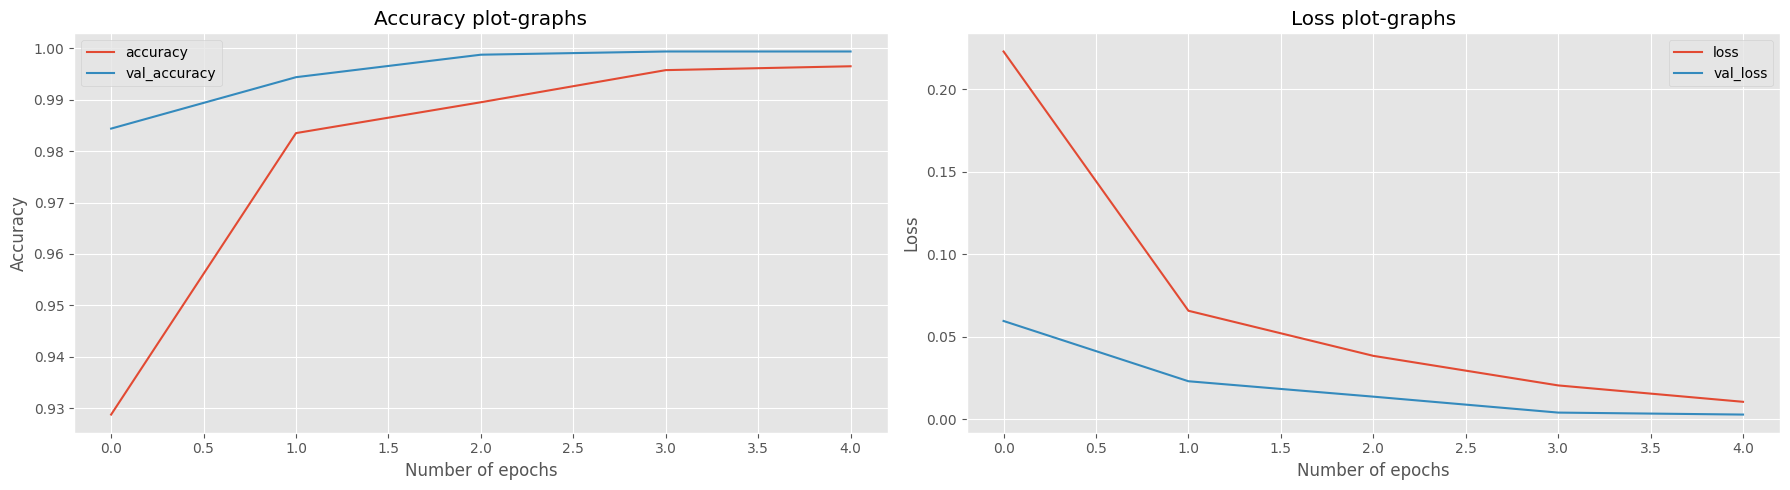

In [53]:
with plt.style.context(style='ggplot'):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    axes[0].plot(history.history["accuracy"],label="accuracy")
    axes[0].plot(history.history["val_accuracy"],label="val_accuracy")
    axes[0].set_title(label='Accuracy plot-graphs')
    axes[0].set_xlabel(xlabel='Number of epochs')
    axes[0].set_ylabel(ylabel='Accuracy')
    axes[0].legend()
    axes[1].plot(history.history["loss"],label="loss")
    axes[1].plot(history.history["val_loss"],label="val_loss")
    axes[1].set_title(label='Loss plot-graphs')
    axes[1].set_xlabel(xlabel='Number of epochs')
    axes[1].set_ylabel(ylabel='Loss')
    axes[1].legend()
    fig.tight_layout()
    plt.show()

In [54]:
prediction=rnn.predict(X_test,batch_size=32,verbose=1)
print(prediction)

50/50 [==============================] - 3s 44ms/step
[[9.9995571e-01 2.5757594e-05]
 [9.4656600e-04 9.9983907e-01]
 [7.6340566e-06 9.9999654e-01]
 ...
 [2.3323317e-07 1.0000000e+00]
 [9.9999738e-01 1.0857017e-06]
 [1.0312867e-08 1.0000000e+00]]


In [55]:
pred=[]
for i in range(len(prediction)):
    pred.append(np.argmax(prediction[i]))
print(pred)

[0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 

In [56]:
y_true=[]
for i in range(len(y_test)):
    y_true.append(np.argmax(y_test[i]))
print(y_true)

[0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 

In [57]:
class_labels=["True","Fake"]

In [58]:
lstm_model_accuracy=accuracy_score(y_true=y_true,y_pred=pred)
print("RecurrentNeuralNetwork model's Validation accuracy is {:.2f}%".format(lstm_model_accuracy*100))

RecurrentNeuralNetwork model's Validation accuracy is 99.94%


In [59]:
print(classification_report(y_true=y_true,y_pred=pred, target_names=class_labels))

              precision    recall  f1-score   support

        True       1.00      1.00      1.00       800
        Fake       1.00      1.00      1.00       800

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



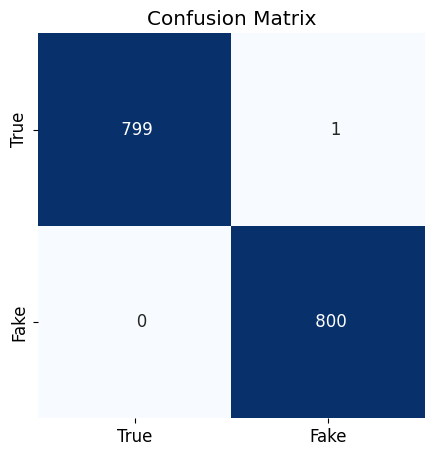

In [60]:
plt.figure(figsize=(5,5))
sns.heatmap(data=confusion_matrix(y_true=y_true,y_pred=pred),
            annot=True,
            fmt='4d',
            cbar=False,
            cmap=plt.cm.Blues,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title(label='Confusion Matrix')
plt.show()

In [61]:
rnn.save("Model/RecurrentNeuralNetwork_model.h5")

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
